# Map Visualizations


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import seaborn as sns
import folium
import geopandas as gpd
import plotly.express as px
from shapely.geometry import Polygon

In [2]:
census_bbox = gpd.read_file('../get_population_data/census_final_data.json',driver= 'GeoJSON')
park_catchment_areas = gpd.read_file('../get_isodistances/isodistances_entrance_park_coordinates.json',driver= 'GeoJSON')
park_centroid_catchment_areas = gpd.read_file('../get_isodistances/isodistances_centroid.json',driver= 'GeoJSON')
park_areas = gpd.read_file('../get_park_data/data.json',driver= 'GeoJSON')


## Folium Ansätze

In [3]:
def map_one_park_polygons(park_df,park_name,census):
    park = park_df[park_df.name == park_name]
    map = folium.Map(location=[53.41535, 9.90225], tiles="CartoDB Positron", zoom_start=11, control_scale = True)
    for _, r in census.iterrows():
        sim_geo_ = gpd.GeoSeries(r["geometry"])
        geo_j_ = sim_geo_.to_json()
        geo_j_ = folium.GeoJson(data=geo_j_, style_function=lambda x: {"fillColor": "orange"})
        folium.Popup(r["row_number"]).add_to(geo_j_)
        geo_j_.add_to(map)
    for _, r in park.iterrows():
        sim_geo = gpd.GeoSeries(r["geometry"])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "green"})
        if 'name' in park.columns:
            folium.Popup(r["name"]).add_to(geo_j)
        geo_j.add_to(map)
    
    return map

In [4]:
def map_multiple_polygons(park,census):
    map = folium.Map(location=[53.41535, 9.90225], tiles="CartoDB Positron", zoom_start=11, control_scale = True)
    for _, r in census.iterrows():
        sim_geo_ = gpd.GeoSeries(r["geometry"])
        geo_j_ = sim_geo_.to_json()
        geo_j_ = folium.GeoJson(data=geo_j_, style_function=lambda x: {"fillColor": "orange"})
        if 'row_number' in census.columns:
            folium.Popup(r["row_number"]).add_to(geo_j_)
        geo_j_.add_to(map)
    for _, r in park.iterrows():
        sim_geo = gpd.GeoSeries(r["geometry"])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "green"})
        if 'name' in park.columns:
            folium.Popup(r["name"]).add_to(geo_j)
        geo_j.add_to(map)
    
    return map

In [5]:
def map_catchment_heatmap(park, catchment_area, park_name, census, sociodemographics):
    map = folium.Map(location=[53.554831, 10.000305], tiles="CartoDB Positron", zoom_start=11, control_scale = False)
    
    # buffering arround park catchment area to get nearest census blocks
    catchment_park_df = catchment_area[catchment_area["name"] == park_name].reset_index()
    park_3395 = catchment_park_df.to_crs(epsg=3395)
    bbox_park = park_3395.buffer(1720,cap_style = 1)

    # convert buffered polygon back to 4326 crs
    envgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox_park))
    bbox_4326 = gpd.GeoDataFrame(envgdf, crs='EPSG:3395')
    bbox_4326 = bbox_4326.to_crs(epsg=4326)
    bbox_4326["name"] = catchment_park_df["name"]
    bbox_4326

    # find subset of census blocks intersecting with buffered catchment area
    intersecting_blocks = gpd.sjoin(census,bbox_4326,how = "inner", predicate="intersects")

    # convert census df to GeoJSON
    census_gjson = intersecting_blocks.to_json()

    # create choropleth and add to map
    folium.Choropleth(
        geo_data = census_gjson,
        name="choropleth",
        data=intersecting_blocks,
        columns =["row_number", sociodemographics],
        key_on = "feature.properties.row_number",
        fill_color="YlOrBr",
        fill_opacity=0.8,
        line_opacity=0.6,
        legend_name="Average Age"
    ).add_to(map)
    
    sozio = folium.features.GeoJson(
    intersecting_blocks, 
    control=False,
    tooltip=folium.features.GeoJsonTooltip(
        fields=[sociodemographics],
        aliases=[sociodemographics]
        ))
    
    # adding catchment area,reduced by park area to map
    park_area = park[park["name"] == park_name].reset_index()
    difference = catchment_park_df["geometry"].difference(park_area["geometry"])
    difference = folium.GeoJson(data=difference, style_function=lambda x: {"fillColor": "green","fillOpacity": 0.9, "color": "green", "stroke":True,"weight":0.5})
    
    difference.add_to(map)
    
    #map.add_child(sozio)
    map.keep_in_front(difference)
    return map

In [6]:
map_catchment_heatmap(park_areas, park_catchment_areas, "Berner Gutspark", census_bbox, "Alter_D")

In [7]:
map_catchment_heatmap(park_areas, park_centroid_catchment_areas, "Berner Gutspark", census_bbox, "Alter_D")

## Matplotlib Ansätze

In [8]:
census_bbox

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,row_number,geometry
0,3,-9.0,0.0,0.00,0.00,-1.00,-1.0,-9.00,-1.0,census_box0,"POLYGON ((9.90980 53.41986, 9.90980 53.41085, ..."
1,3,-9.0,0.0,100.00,0.00,-1.00,-1.0,-9.00,-1.0,census_box1,"POLYGON ((10.16561 53.46473, 10.16561 53.45572..."
2,3,-9.0,0.0,0.00,0.00,-1.00,-1.0,-9.00,-1.0,census_box2,"POLYGON ((9.92465 53.51871, 9.92465 53.50972, ..."
3,3,-9.0,0.0,0.00,100.00,-1.00,-1.0,-1.00,-1.0,census_box3,"POLYGON ((9.93970 53.52771, 9.93970 53.51871, ..."
4,7,-9.0,-9.0,0.00,57.14,1.40,-1.0,-1.00,-1.0,census_box4,"POLYGON ((10.22615 53.52753, 10.22615 53.51853..."
...,...,...,...,...,...,...,...,...,...,...,...
857,30,68.0,0.0,76.67,-9.00,1.43,0.0,58.30,78.0,census_box857,"POLYGON ((9.98488 53.62656, 9.98488 53.61759, ..."
858,4,70.0,0.0,-9.00,0.00,-1.00,-1.0,-9.00,-1.0,census_box858,"POLYGON ((10.24068 53.42866, 10.24068 53.41965..."
859,3,71.0,0.0,-9.00,0.00,-1.00,-1.0,21.33,-1.0,census_box859,"POLYGON ((10.21107 53.52755, 10.21107 53.51856..."
860,3,73.0,0.0,-9.00,0.00,2.00,0.0,-9.00,-9.0,census_box860,"POLYGON ((9.83432 53.49166, 9.83432 53.48266, ..."


In [9]:
#imputation means für -9 value
def impute_means(df):
    df = df.replace(-1,0)
    sociodemographic_columns = ["Einwohner", "Alter_D", "unter18_A", "ab65_A", "Auslaender_A", "HHGroesse_D", "Leerstandsquote", "Wohnfl_Bew_D", "Wohnfl_Whg_D"]
    df[sociodemographic_columns] = df[sociodemographic_columns].replace(-9, pd.NA)
    mean_values = df.groupby("name")[sociodemographic_columns].mean()
    df[sociodemographic_columns] = df.apply(lambda row: row[sociodemographic_columns].combine_first(mean_values.loc[row["name"]]), axis=1)
    return df

In [10]:
def function(census,df,park_name, park_area):
    catchment_park_df = df[df["name"] == park_name]
    park_area = park_area[park_area["name"] == park_name]
    
    # find subset of census blocks intersecting with buffered catchment area
    intersecting_blocks = gpd.sjoin(census,catchment_park_df,how = "inner", predicate="intersects")
    
    # fill -1 and -9 values with 0 and mean
    intersecting_blocks = impute_means(intersecting_blocks)

    def extract_points_from_polygon(polygon):
        return list(polygon.exterior.coords)
    
    intersecting_blocks["coords_list"] = intersecting_blocks["geometry"].apply(extract_points_from_polygon)

    # plotting census blocks
    fig, ax = plt.subplots()
    patches = []

    for i in intersecting_blocks["geometry"]:
        print(i)
        patches.append(i)
    
    p = PatchCollection(patches)
    ax.add_collection(p, alpha = 0.25)
    ax.autoscale()

    plt.show()

POLYGON ((10.135989232344917 53.62649265769564, 10.135989232344917 53.61752040485017, 10.120897535571709 53.61752040485017, 10.120897535571709 53.62649265769564, 10.135989232344917 53.62649265769564))
POLYGON ((10.136016355591924 53.6354777492103, 10.136016355591924 53.62650741568854, 10.120924658818717 53.62650741568854, 10.120924658818717 53.6354777492103, 10.136016355591924 53.6354777492103))
POLYGON ((10.151100183539928 53.626475801178344, 10.151100183539928 53.617503544732315, 10.13600848676672 53.617503544732315, 10.13600848676672 53.626475801178344, 10.151100183539928 53.626475801178344))
POLYGON ((10.151130497729714 53.635460888620734, 10.151130497729714 53.62649055149715, 10.136038800956507 53.62649055149715, 10.136038800956507 53.635460888620734, 10.151130497729714 53.635460888620734))


AttributeError: 'Polygon' object has no attribute 'get_transform'

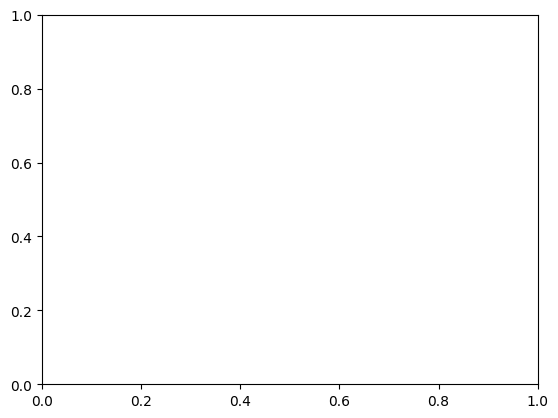

In [11]:
function(census_bbox,park_catchment_areas, "Berner Gutspark", park_areas)